In this notebook i have worked on visualization of Input data for the kaggle Hubmap competition. 
I have also converted tiff files to png files.
for this notebook i have followed
https://www.kaggle.com/code/itsuki9180/hubmap-making-dataset

In [1]:
import os
import json
from PIL import Image
from collections import Counter

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import tifffile as tiff
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import io

In [2]:
#! pip install imagecodecs
#! pip install -U kaleido

In [3]:
Root_folder_path = "/home/ds/Desktop/kaggle-hubmap/"
Data_path  = os.path.join(Root_folder_path , "data")

In [4]:
json_file_path = os.path.join(Data_path ,'polygons.jsonl' )
with open(json_file_path , 'r') as json_file :
    json_list = list(json_file)

In [5]:
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [6]:
tile_meta_file_name = 'tile_meta.csv'
tile_meta_df = pd.read_csv(os.path.join(Data_path , tile_meta_file_name))
tile_meta_df.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


In [7]:
glomCount = 0 
blood_vess_count = 0
unknown = 0
for data  in tiles_dicts:
    a = data['annotations'][0]['type']
    if a == "glomerulus":
        glomCount += 1
    elif  a == 'blood_vessel' :
        blood_vess_count += 1
    else :
        unknown +=1
        
print("glomerulus Count = " ,glomCount , '\n' , "Blood vessel count = ", blood_vess_count)
print('unknown = ', unknown)

glomerulus Count =  150 
 Blood vessel count =  1372
unknown =  111


In [16]:
def get_cartesian_coords(coords, img_height):
    coords_array = np.array(coords).squeeze()
    xs = coords_array[:, 0]
    ys = -coords_array[:, 1] + img_height
    
    return xs, ys

img_data_dir = os.path.join(Data_path , 'train')

def plotly_fig2array(fig):
    #convert Plotly fig to  an array
    fig_bytes = fig.to_image(format="png")
    buf = io.BytesIO(fig_bytes)
    img = Image.open(buf)
    return np.asarray(img)

def plot_annotated_image(image_dict,show = True ,  scale_factor: int = 1.0) -> None:
    #array = tiff.imread(CFG.img_path_template.format(image_dict["id"]))
    
    array = tiff.imread(os.path.join(img_data_dir , f'{image_dict["id"]}.tif'))
    
    img_example = Image.fromarray(array)
    annotations = image_dict["annotations"]
    
    # create figure
    fig = go.Figure()

    # constants
    img_width = img_example.size[0]
    img_height = img_example.size[1]
    

    # add invisible scatter trace
    fig.add_trace(
        go.Scatter(
            x=[0, img_width],
            y=[0, img_height],
            mode="markers",
            marker_opacity=0
        )
    )

    # configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # add image
    fig.add_layout_image(dict(
        x=0,
        sizex=img_width,
        y=img_height,
        sizey=img_height,
        xref="x", yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_example
    ))
    
    # add polygons
    for annotation in annotations:
        name = annotation["type"]
        xs, ys = get_cartesian_coords(annotation["coordinates"], img_height)
        fig.add_trace(go.Scatter(
            x=xs, y=ys, fill="toself",
            name=name,
            hovertemplate="%{name}",
            mode='lines'
        ))

    # configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        showlegend=False
    )

    # disable the autosize on double click because it adds unwanted margins around the image
    # and finally show figure
    if show :
        fig.show(config={'doubleClick': 'reset'})
    
    return plotly_fig2array(fig)

    


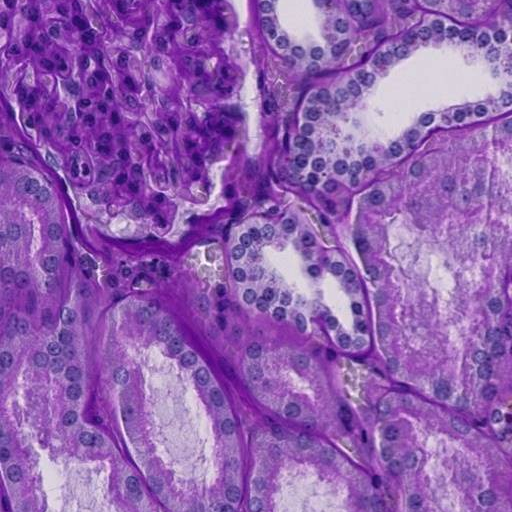

In [17]:
res = plot_annotated_image(tiles_dicts[0])

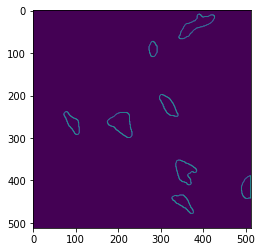

In [11]:
mask = np.zeros((512, 512), dtype=np.float32)
for annot in tiles_dicts[0]['annotations']:
    cords = annot['coordinates']
    if annot['type'] == "blood_vessel":
        for cd in cords:
            rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
            mask[rr, cc] = 1
            
plt.imshow(mask)
plt.show()

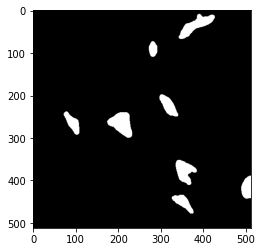

In [12]:
contours,_ = cv2.findContours((mask*255).astype(np.uint8), 1, 2)
zero_img = np.zeros([mask.shape[0], mask.shape[1], 3], dtype="uint8")

for p in contours:
    cv2.fillPoly(zero_img, [p], (255, 255, 255))
    
plt.imshow(zero_img)
plt.show()

(512, 512, 3)
16


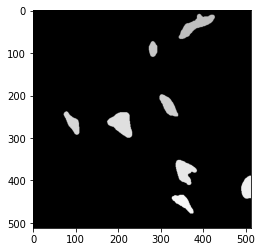

In [13]:
from copy import deepcopy
contours, hierarchy = cv2.findContours(mask.astype("uint8"), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
img_with_area = zero_img
print(img_with_area.shape)

print(len(contours))
        
for i in range(len(contours)):
    if cv2.contourArea(contours[i]) > (mask.shape[0] * mask.shape[1]) * 0.0001:
        cv2.fillPoly(img_with_area, [contours[i][:,0,:]], (255-4*(i+1),255-4*(i+1),255-4*(i+1)), lineType=cv2.LINE_8, shift=0)
        
plt.imshow(img_with_area)
plt.show()

In [14]:
def make_seg_mask(tiles_dict):
    mask = np.zeros((512, 512), dtype=np.float32)
    for annot in tiles_dict['annotations']:
        cords = annot['coordinates']
        if annot['type'] == "blood_vessel":
            for cd in cords:
                rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                mask[rr, cc] = 1
                
    contours,_ = cv2.findContours((mask*255).astype(np.uint8), 1, 2)
    zero_img = np.zeros([mask.shape[0], mask.shape[1], 3], dtype="uint8")

    for p in contours:
        cv2.fillPoly(zero_img, [p], (255, 255, 255))

    contours, hierarchy = cv2.findContours(mask.astype("uint8"), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    img_with_area = zero_img

    for i in range(len(contours)):
        cv2.fillPoly(img_with_area, [contours[i][:,0,:]], (255-4*(i+1),255-4*(i+1),255-4*(i+1)), lineType=cv2.LINE_8, shift=0)
            
    return img_with_area 

In [21]:
png_img_path = os.path.join(Data_path , "train_img_png")
png_mask_path = os.path.join(Data_path , "train_mask_png")
plotted_img = os.path.join(Data_path , "img_plot")
os.makedirs(png_img_path, exist_ok=True)
os.makedirs(png_mask_path, exist_ok=True)
os.makedirs(plotted_img, exist_ok=True)

for i, tldc in enumerate(tqdm(tiles_dicts)):
    array = tiff.imread(os.path.join(Data_path , f'train/{tldc["id"]}.tif'))
    img_example = Image.fromarray(array)
    img = np.array(img_example)
    mask = make_seg_mask(tldc)
    
    if np.sum(mask)>0:
        print(f'{tldc["id"]}.png')
        cv2.imwrite(os.path.join(png_img_path , f'{tldc["id"]}.png'), img)
        cv2.imwrite(os.path.join(png_mask_path , f'{tldc["id"]}.png'), mask)
        cv2.imwrite(os.path.join(plotted_img , f'{tldc["id"]}.png'), plot_annotated_image(tldc , show = False))
        
    break

  0%|          | 0/1633 [00:00<?, ?it/s]

0006ff2aa7cd.png


  0%|          | 0/1633 [00:00<?, ?it/s]
